# AGP Plotting
Use this script to plot a visual comparison between AGPs and RGPs.  Adapt the variables below to adapt to different datasets or RAs.

In [ ]:
models = ['Random', 'MostPop', 'RP3beta', 'iALS']
dataset = 'bx'

In [106]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import utils.genre_processing as gp
import utils.file_handler as fh
import utils.age_processing as ap

In [ ]:
ages_sort = ap.get_sorted_ages(dataset, 'defined_ages')
child_group = ages_sort[0]
mainstream_group = ages_sort[1]


In [108]:
results_path = f'../Results/{dataset}/user_and_recommendation_genre_distributions.tsv'
genres = gp.get_genres(dataset)

In [109]:
results = pd.read_csv(results_path, sep='\t')

In [110]:
for column in results.columns:
    if 'genre_distribution' in column:
        results[column] = results[column].apply(fh.safe_literal_eval)

In [111]:
mainstream_distribution = results[results['age_group'] == mainstream_group]['train_genre_distribution'].apply(lambda x: gp.genre_dict_to_list(x, dataset)).apply(np.array).mean(axis=0)
child_distribution = results[results['age_group'] == child_group]['train_genre_distribution'].apply(lambda x: gp.genre_dict_to_list(x, dataset)).apply(np.array).mean(axis=0)


In [112]:
data = []


for age in ages_sort:
    age_group = results[results['age_group']==age]

    mean_genre_dict = {'age': f'{age}', 'model': f'AGP$_{{{age}}}$', 'dataset' : ''}
    for index, genre in enumerate(genres):
        mean_genre_dict[genre] = age_group['train_genre_distribution'].apply(lambda x: gp.genre_dict_to_list(x, dataset)).apply(lambda x: x[index]).mean()
    data.append(mean_genre_dict)
    
    if age == child_group:
        for model in models:
            mean_genre_dict = {'age': f'{age}', 'model': model, 'dataset' : 'child-focused'}
            for index, genre in enumerate(genres):
                mean_genre_dict[genre] = age_group[f'child_{model}_genre_distribution'].apply(lambda x: gp.genre_dict_to_list(x, dataset)).apply(lambda x: x[index]).mean()
            data.append(mean_genre_dict)
       
    for model in models:
        mean_genre_dict = {'age': f'{age}', 'model': model, 'dataset' : 'unbalanced'}
        for index, genre in enumerate(genres):
            mean_genre_dict[genre] = age_group[f'{model}_genre_distribution'].apply(lambda x: gp.genre_dict_to_list(x, dataset)).apply(lambda x: x[index]).mean()
        data.append(mean_genre_dict)
    

In [113]:
mean_genre_df = pd.DataFrame(data)

mean_genre_df = mean_genre_df[['age', 'model', 'dataset'] + genres]

print(mean_genre_df)

# Create a unique index combining age, dataset, and model
mean_genre_df['age_dataset_model'] = mean_genre_df['age'] + '*' + mean_genre_df['dataset'] + '*' + mean_genre_df['model']

mean_genre_df = mean_genre_df.drop(columns=['age', 'dataset', 'model'])

# Set this as the index
mean_genre_df = mean_genre_df.set_index('age_dataset_model')

      age          model        dataset  comics_graphic  fantasy_paranormal  \
0   12-17  AGP$_{12-17}$                       0.023464            0.207465   
1   12-17         Random  child-focused        0.020489            0.182256   
2   12-17        MostPop  child-focused        0.019398            0.290038   
3   12-17        RP3beta  child-focused        0.026128            0.211692   
4   12-17           iALS  child-focused        0.021203            0.239323   
5   12-17         Random     unbalanced        0.020326            0.154311   
6   12-17        MostPop     unbalanced        0.019398            0.179925   
7   12-17        RP3beta     unbalanced        0.019424            0.218058   
8   12-17           iALS     unbalanced        0.018308            0.203346   
9   18-49  AGP$_{18-49}$                       0.020554            0.171236   
10  18-49         Random     unbalanced        0.017864            0.152400   
11  18-49        MostPop     unbalanced        0.019

age_dataset_model
12-17**AGP$_{12-17}$           0.023464
12-17*child-focused*Random     0.020489
12-17*child-focused*MostPop    0.019398
12-17*child-focused*RP3beta    0.026128
12-17*child-focused*iALS       0.021203
12-17*unbalanced*Random        0.020326
12-17*unbalanced*MostPop       0.019398
12-17*unbalanced*RP3beta       0.019424
12-17*unbalanced*iALS          0.018308
18-49**AGP$_{18-49}$           0.020554
18-49*unbalanced*Random        0.017864
18-49*unbalanced*MostPop       0.019667
18-49*unbalanced*RP3beta       0.019979
18-49*unbalanced*iALS          0.018050
50-65**AGP$_{50-65}$           0.008371
50-65*unbalanced*Random        0.017410
50-65*unbalanced*MostPop       0.019884
50-65*unbalanced*RP3beta       0.013130
50-65*unbalanced*iALS          0.012016
Name: comics_graphic, dtype: float64
age_dataset_model
12-17**AGP$_{12-17}$           0.207465
12-17*child-focused*Random     0.182256
12-17*child-focused*MostPop    0.290038
12-17*child-focused*RP3beta    0.211692
12-17*c

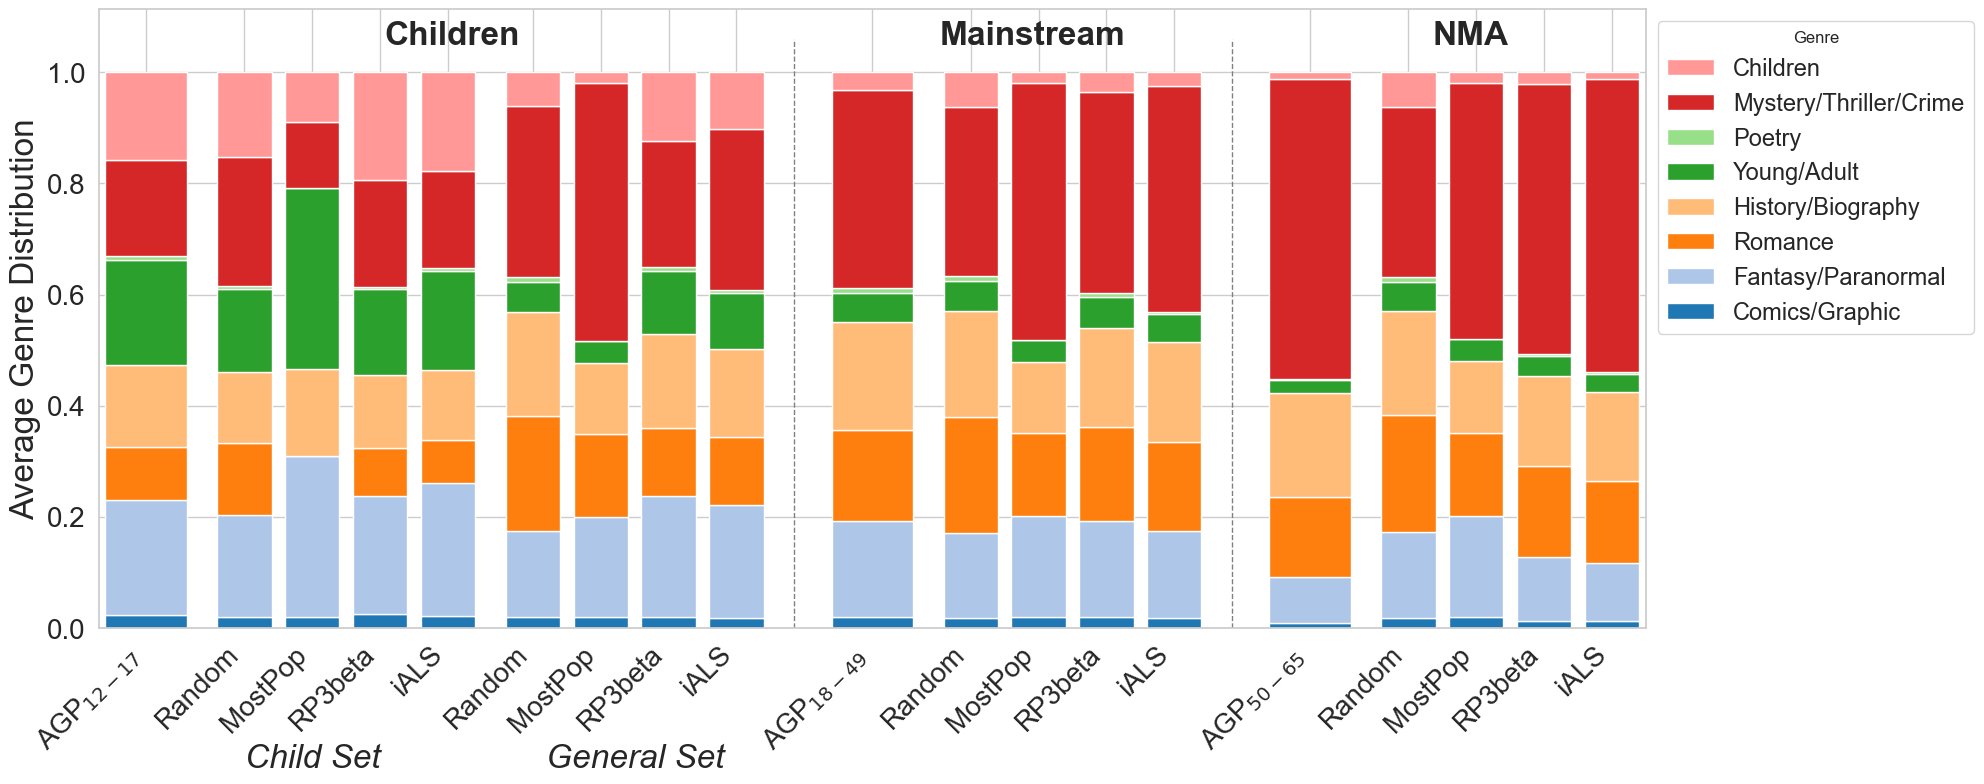

In [114]:

# Set the plot style
plt.figure(figsize=(20, 8))  
sns.set(style='whitegrid')



# Prepare variables
bar_positions = np.arange(len(mean_genre_df), dtype=float)  # Ensure positions are float
bar_widths = np.ones_like(bar_positions) * 0.8  # Default width for all bars

wider_bars = [0, 9, 14]  # Indexes of bars to make wider
extra_width = 0.2  # Additional width for the wider bars
# Modify specific bars
bar_widths[wider_bars] = 1 + extra_width  # Make the 1st, 10th, and 15th bars wider

# Insert gaps after specific bars by adding space to positions
gaps = [8, 13]  # After which bars to insert space
space = 1  # Amount of space to insert

small_gaps = [0, 4, 9, 14]
small_space = 0.25

for gap in gaps:
    bar_positions[gap + 1:] += space  # Shift bars after the specified ones

for bar in wider_bars:
    bar_positions[bar + 1:] += extra_width  # Shift bars after the specified ones

for gap in small_gaps:
    bar_positions[gap + 1:] += small_space  # Shift bars after the specified ones

# Plot manually for each column in the DataFrame (each genre)
bottoms = np.zeros(len(mean_genre_df))

colors = sns.color_palette('tab20', n_colors=len(mean_genre_df.columns))
for genre in mean_genre_df.columns:
    plt.bar(bar_positions, mean_genre_df[genre], width=bar_widths, bottom=bottoms, label=genre, color=colors.pop(0))
    print(mean_genre_df[genre])
    bottoms += mean_genre_df[genre]

# Add text centered between the first and 9th bar
plt.text(np.mean(bar_positions[:9]), 1.05, 'Children', ha='center', fontsize=24, fontweight='bold')
plt.text(np.mean(bar_positions[9:14]), 1.05, 'Mainstream', ha='center', fontsize=24, fontweight='bold')
plt.text(np.mean(bar_positions[14:]), 1.05, 'NMA', ha='center', fontsize=24, fontweight='bold')

plt.text(np.mean(bar_positions[1:4]), -0.25, 'Child Set', ha='center', fontsize=24, style='italic')
plt.text(np.mean(bar_positions[5:9]), -0.25, 'General Set', ha='center', fontsize=24, style='italic')

plt.vlines(bar_positions[9]-1.15, 0, 1.06, color='grey', linewidth=1, linestyles='dashed')
plt.vlines(bar_positions[14]-1.15, 0, 1.06, color='grey', linewidth=1, linestyles='dashed')

plt.ylabel('Average Genre Distribution', fontsize=24)

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['/'.join([l.capitalize() for l in label.split('_')]) for label in labels]
plt.legend(handles[::-1], labels[::-1], title='Genre', 
           bbox_to_anchor=(1, 1), loc='upper left', fontsize=17)


x_labels = [model for age_group, dataset, model in mean_genre_df.index.str.split("*")]

# Setting xticks and yticks formatting
plt.xticks(bar_positions, x_labels, rotation=45, fontsize=20, ha='right')
plt.yticks(fontsize=20)

plt.xlim(bar_positions.min() - 0.7, bar_positions.max() + 0.5)

# Adjust layout to fit all elements
plt.tight_layout()
plt.savefig(f'../Results/Age_Genre_Profiles_{dataset}.pdf')
# Show the plot
plt.show()